# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


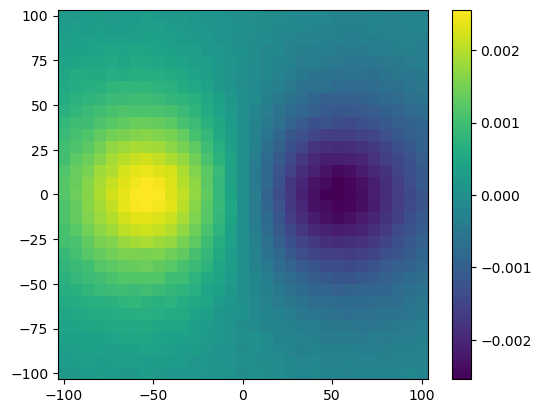

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f4ac68cafd0>,)

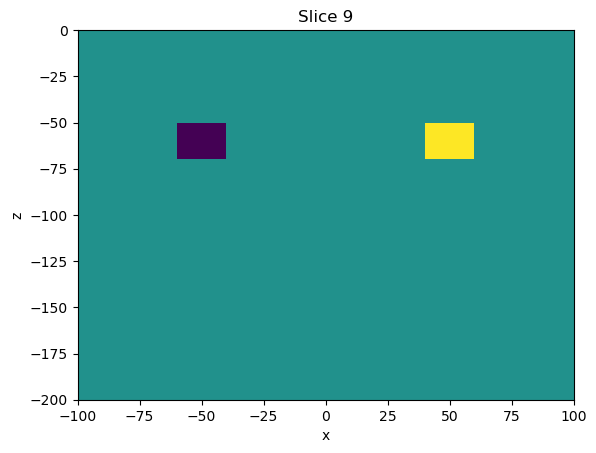

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

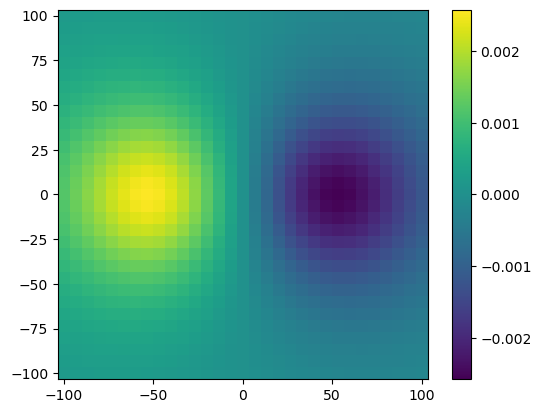

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = GravitySimulation(simulation_simpeg)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
sparse_smallness = ii.SparseSmallness(
    n_params=simulation.n_params, 
    norm=1,
    model_previous=None,
    weights=volume_weights * depth_weights,
    irls=False, # Start with IRLS deactivated
)

In [17]:
beta_0 = 1e4
regularization = beta_0 * sparse_smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+04 φss(m)

In [18]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
chi_target = ii.ChiTarget(data_misfit, chi_target=1.0)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
l2_inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=chi_target,
    cache_models=True,
)

In [19]:
model_l2 = l2_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [20]:
l2_inversion.stopping_criteria.info(model_l2)

[x] ChiTarget
├── Condition: chi < chi_target
├── chi        = 8.83e-01
└── chi_target = 1.00e+00

(<matplotlib.collections.QuadMesh at 0x7f4ac6ae7ed0>,)

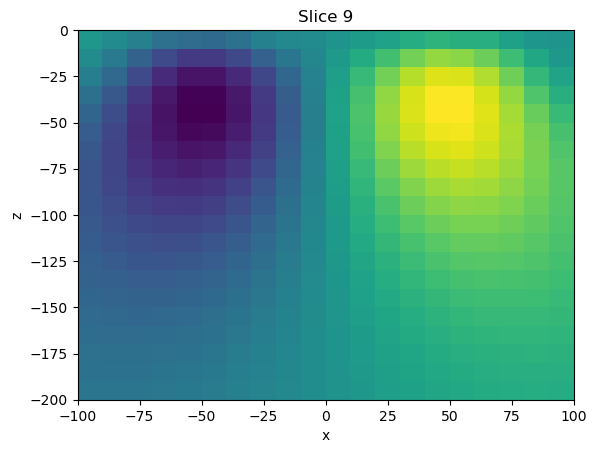

In [21]:
mesh.plot_slice(model_l2, normal="Y", slice_loc=0)

In [22]:
# Activate IRLS in smallness
# * Assign model to sparse smallness as previous model
# * Define epsilon: maximum abs value of the inverted model after the l2 inversion
sparse_smallness.activate_irls(model_l2)

# Define stopping criteria
smallness_not_changing = ii.ObjectiveChanged(sparse_smallness, rtol=1e-3)

sparse_inversion = ii.Inversion(
    phi,
    model_l2,
    minimizer,
    directives=[],  # leave empty directives now, will handle manually
    stopping_criteria=smallness_not_changing,
    cache_models=True,
    max_iterations=40,
)

# Add columns to log
sparse_inversion.log.columns["irls threshold"] = lambda _, __: f"{sparse_smallness.threshold:.2e}"

dmisfit_changed = ii.ObjectiveChanged(data_misfit)
dmisfit_changed.previous = data_misfit(model_l2)
sparse_inversion.log.columns["|phi_d - phi_d*| / |phi_d*|"] = lambda _, model: f"{dmisfit_changed.ratio(model):.2e}"

sparse_inversion.log.columns["|phi_m - phi_m*| / |phi_m*|"] = lambda _, model: f"{smallness_not_changing.ratio(model):.2e}"

In [23]:
# Define cooling rate for IRLS threshold (epsilon)
threshold_cooling_rate = 1.25

# Define a stopping criteria for the data misfit.
# Compare it always with the data misfit obtained with the model from l2 inversion.
dmisfit_below_threshold = ii.ObjectiveChanged(data_misfit, rtol=1e-1)
dmisfit_l2 = data_misfit(model_l2)
dmisfit_below_threshold.previous = dmisfit_l2 

with sparse_inversion.log.live() as live:
    for model in sparse_inversion:

        if not dmisfit_below_threshold(model):
            # Cool beta if the data misfit is quite different from the l2 one
            phi_d = data_misfit(model)
            #   Adjust the cooling factor (following current implementation of UpdateIRLS)
            if phi_d > dmisfit_l2:
                beta_cooler.cooling_factor = 1 / np.mean([0.75, dmisfit_l2 / phi_d])
            else:
                beta_cooler.cooling_factor = 1 / np.mean([2.0, dmisfit_l2 / phi_d])
            beta_cooler(model, sparse_inversion.counter)

        else:
            # Cool the irls threshold (epsilon)
            sparse_smallness.threshold /= threshold_cooling_rate
            # Assign current model as previous one to sparse 
            sparse_smallness.model_previous = model
        live.refresh()
    

Output()

INFO: ⚠️ Inversion finished after reaching maximum number of iterations (40).


In [24]:
log = pd.DataFrame(sparse_inversion.log.log).set_index("iter")
log

,β,φ_d,φ_m,β φ_m,φ,χ,irls threshold,|phi_d - phi_d*| / |phi_d*|,|phi_m - phi_m*| / |phi_m*|
iter,,,,,,,,,
0,39.062500,848.655048,61414.537654,2.399005e+06,2.399854e+06,0.883096,3.24e-03,0.00e+00,nan
1,39.062500,463482.697523,9981.158001,3.898890e+05,8.533717e+05,482.292089,3.24e-03,5.45e+02,8.37e-01
2,14.684200,182022.829519,21554.206747,3.165063e+05,4.985291e+05,189.409812,3.24e-03,2.13e+02,1.16e+00
3,5.540806,57442.525324,34854.465234,1.931218e+05,2.505644e+05,59.773700,3.24e-03,6.67e+01,6.17e-01
4,2.118732,14955.056674,46557.575059,9.864304e+04,1.135981e+05,15.561974,3.24e-03,1.66e+01,3.36e-01
5,0.854641,3983.535010,54163.061191,4.628995e+04,5.027348e+04,4.145198,3.24e-03,3.69e+00,1.63e-01
6,0.411527,1660.402083,57885.721981,2.382153e+04,2.548193e+04,1.727786,3.24e-03,9.57e-01,6.87e-02
7,0.259491,1135.204087,59460.856886,1.542957e+04,1.656477e+04,1.181274,3.24e-03,3.38e-01,2.72e-02
8,0.194304,957.800588,60245.073504,1.170588e+04,1.266368e+04,0.996671,3.24e-03,1.29e-01,1.32e-02


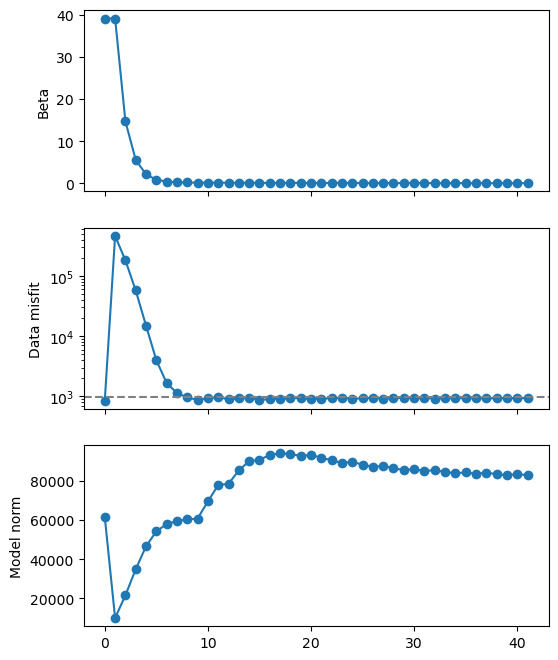

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.β, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.φ_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.φ_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

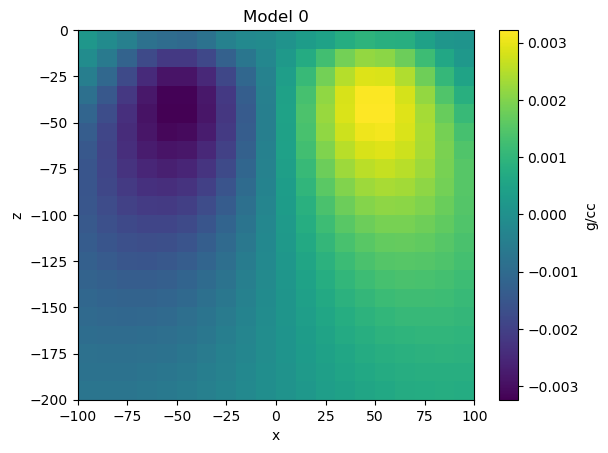

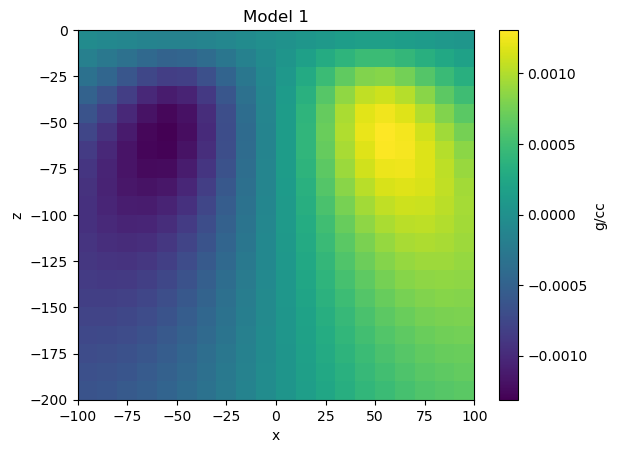

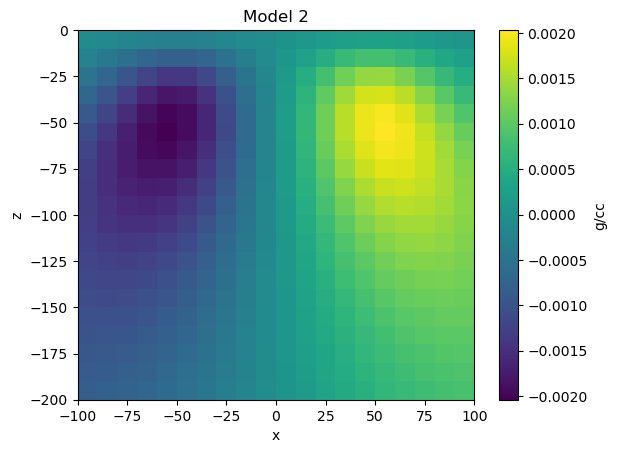

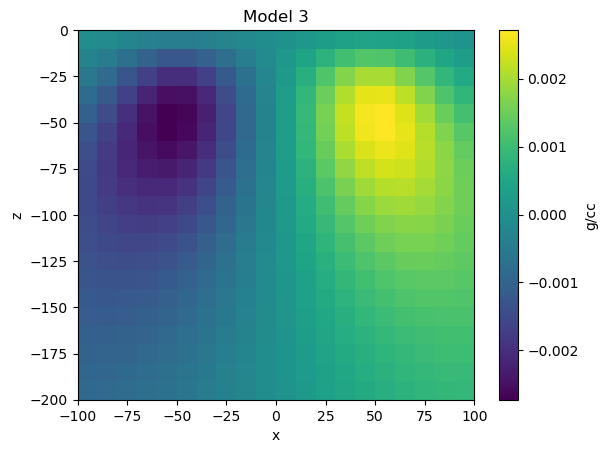

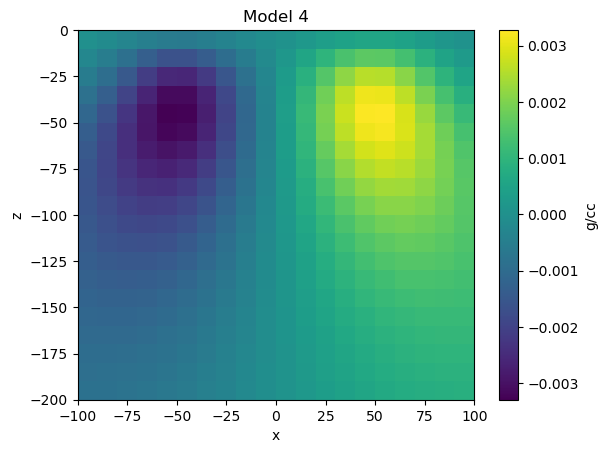

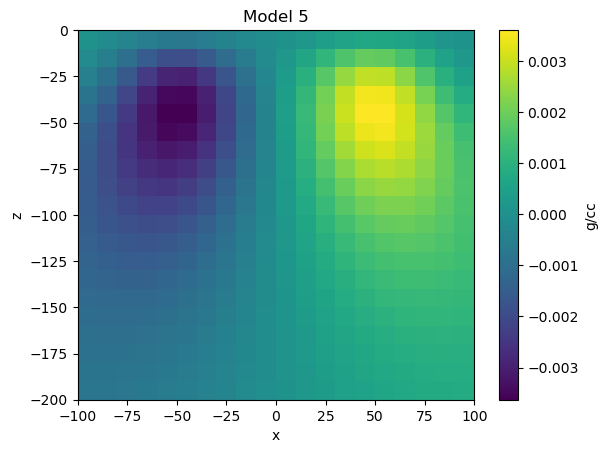

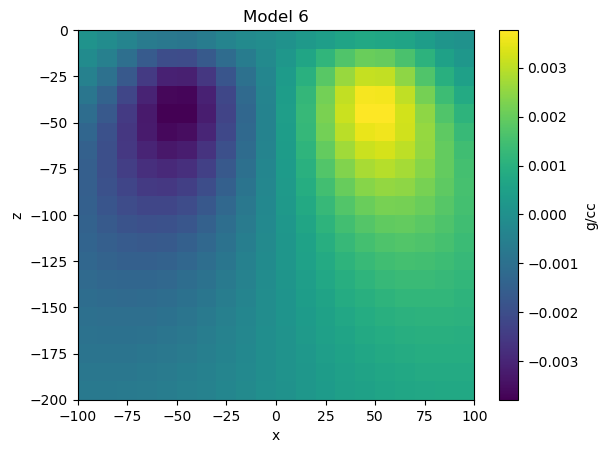

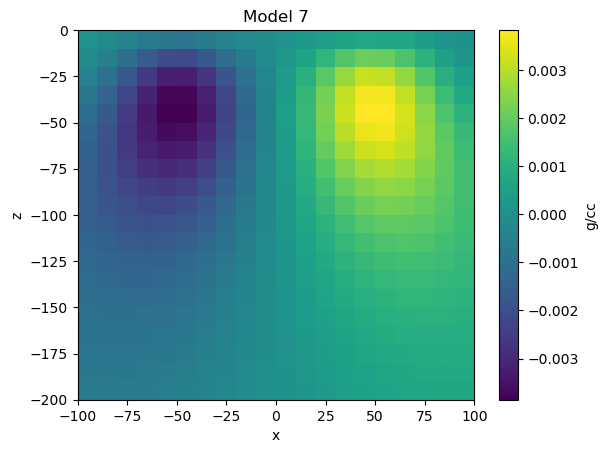

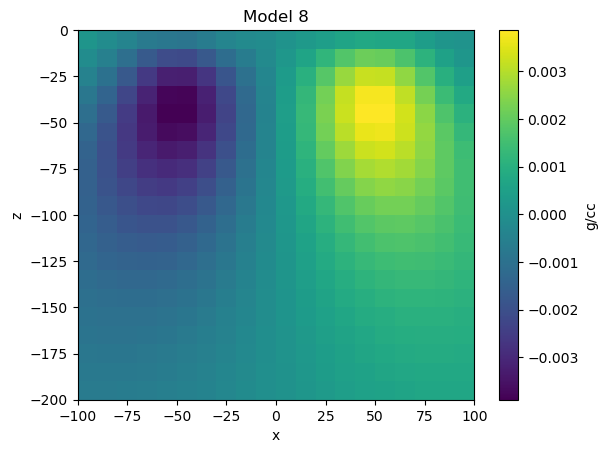

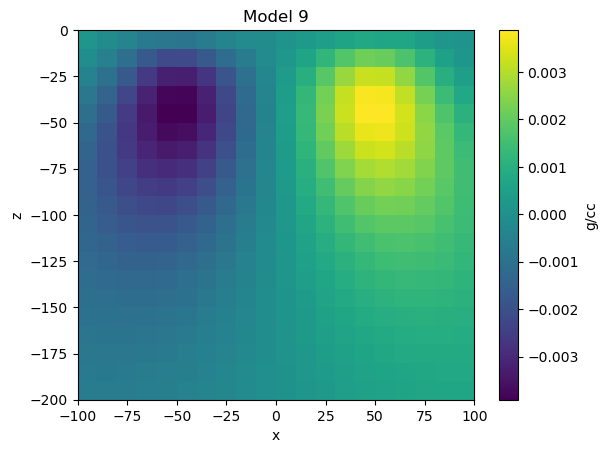

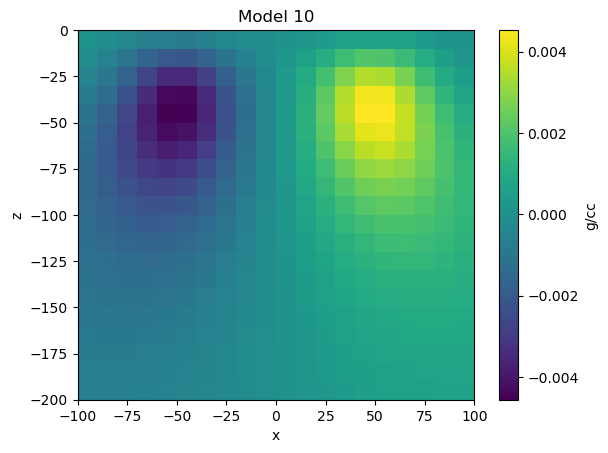

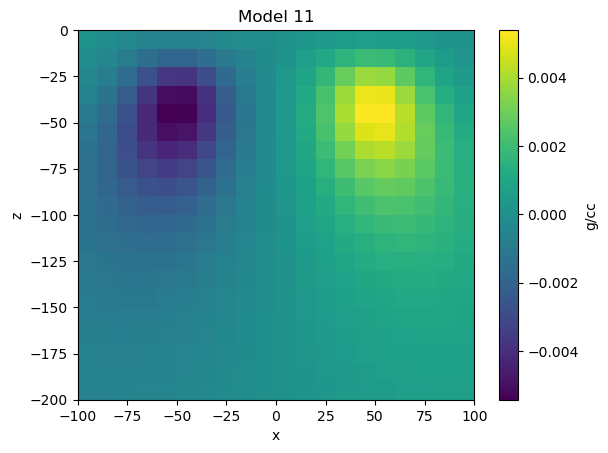

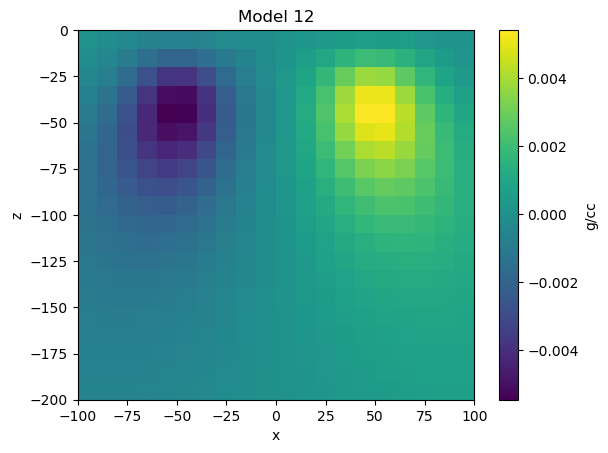

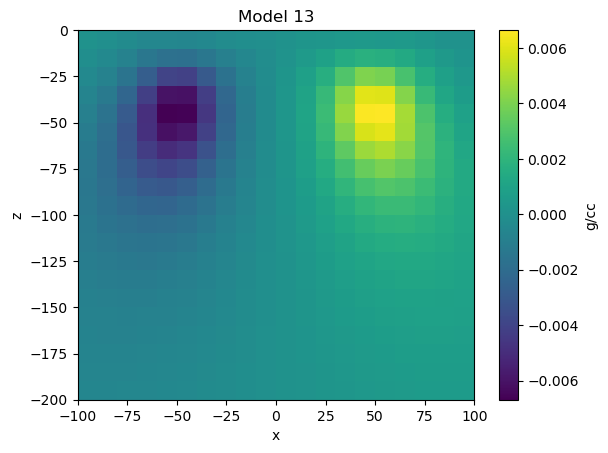

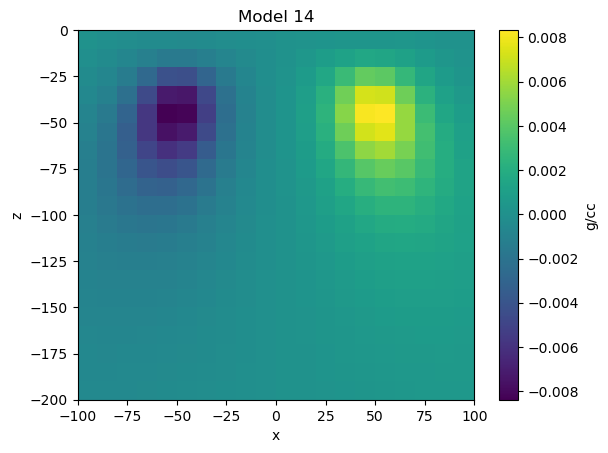

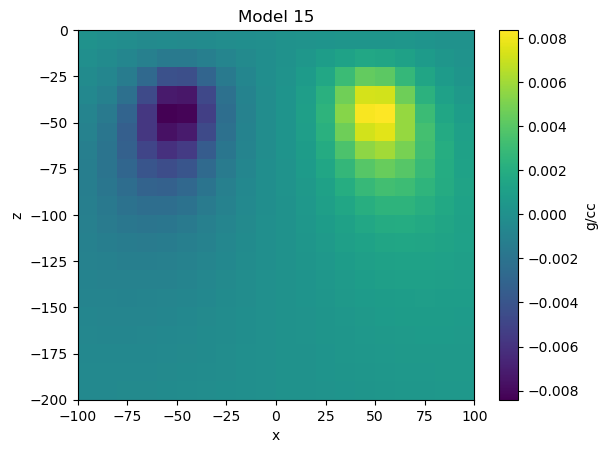

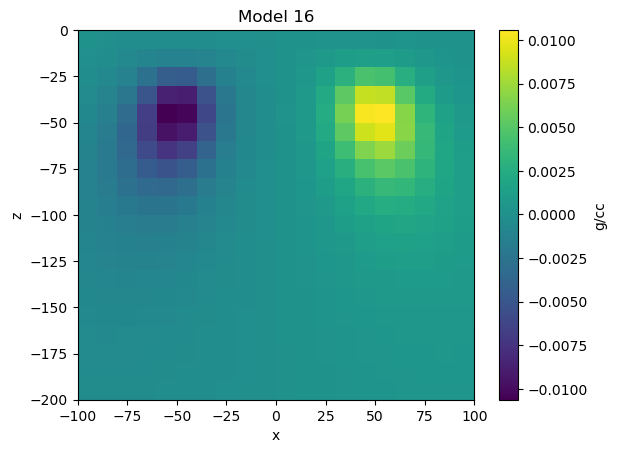

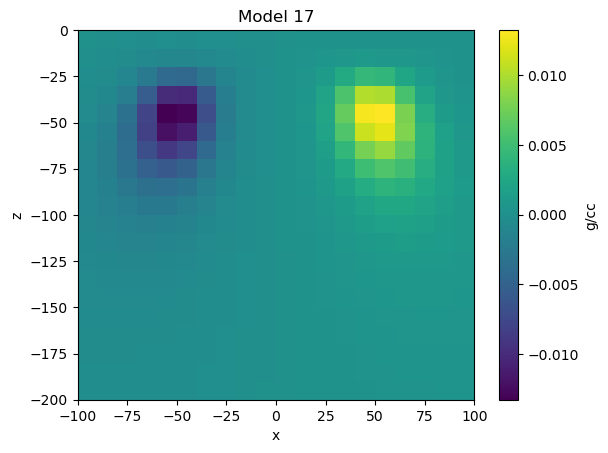

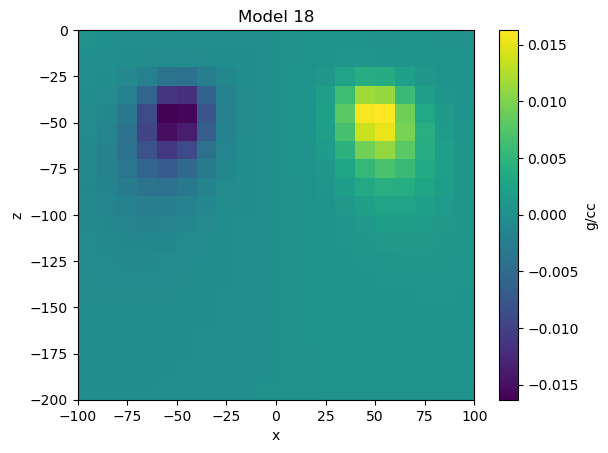

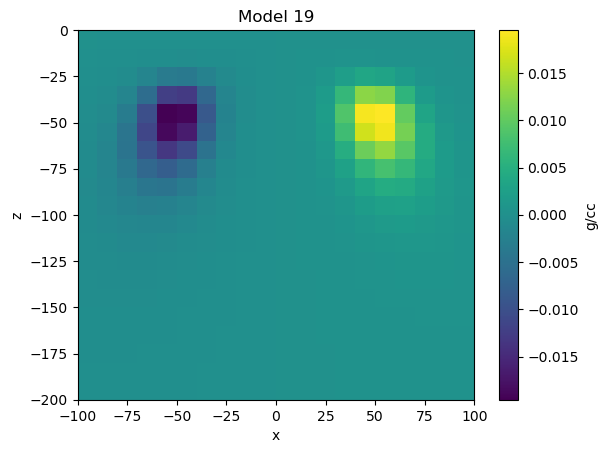

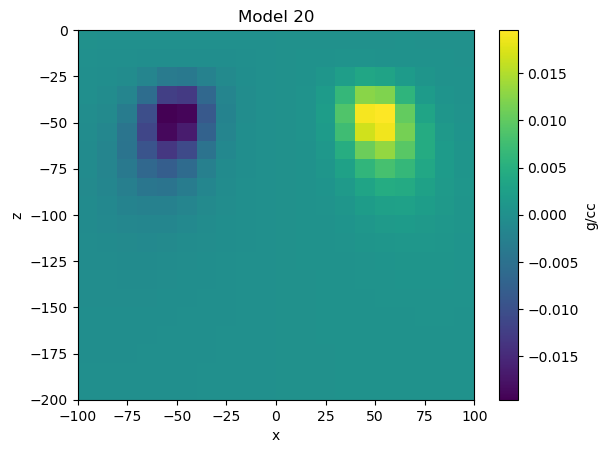

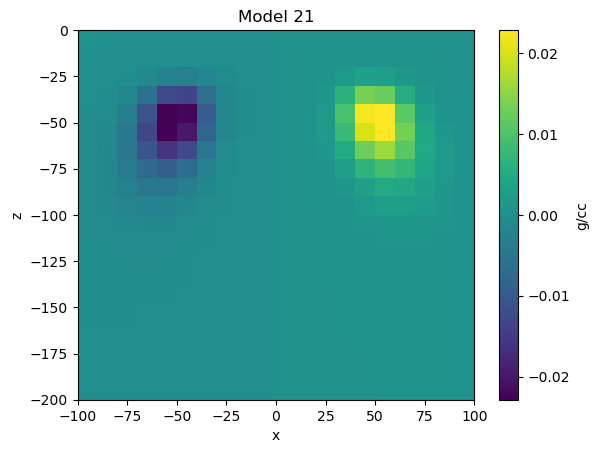

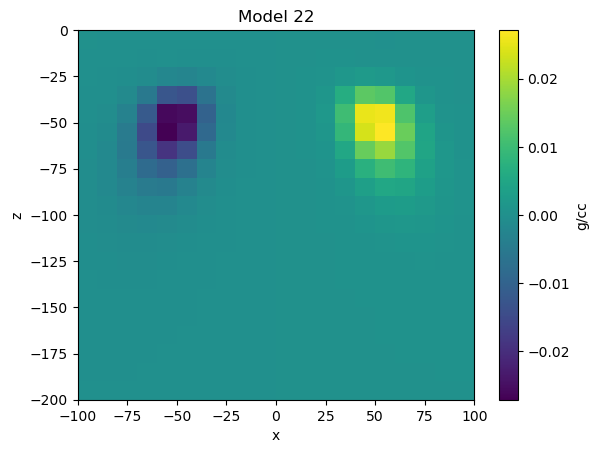

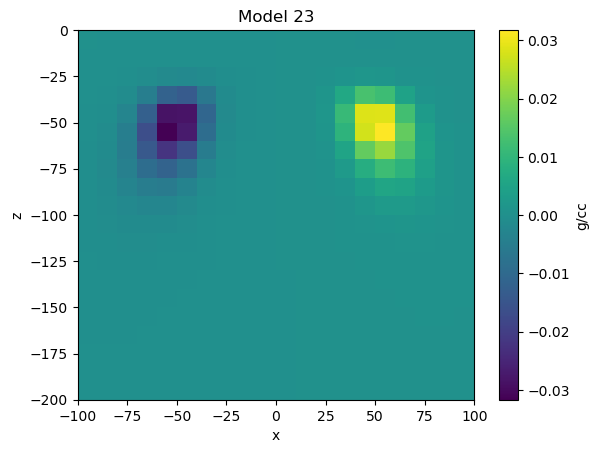

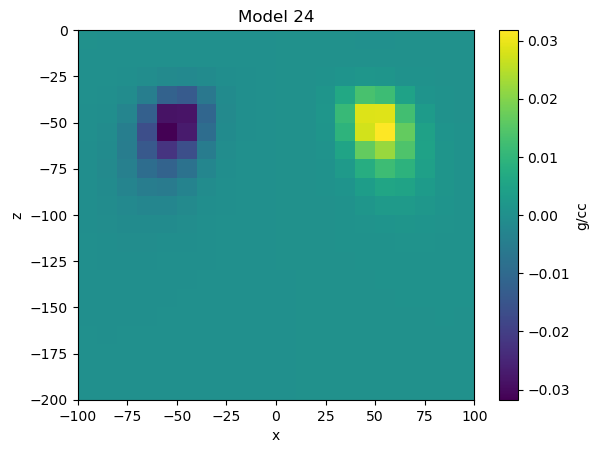

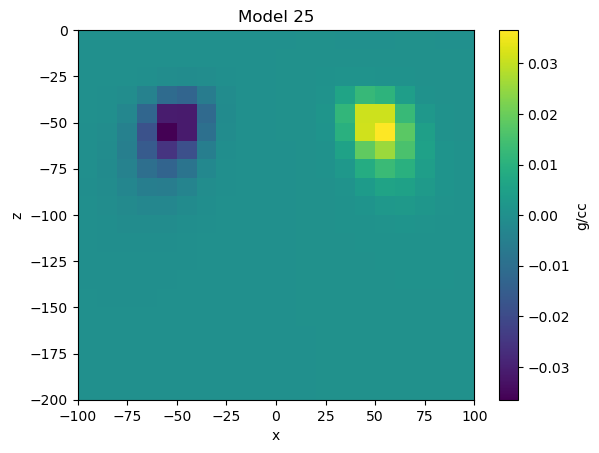

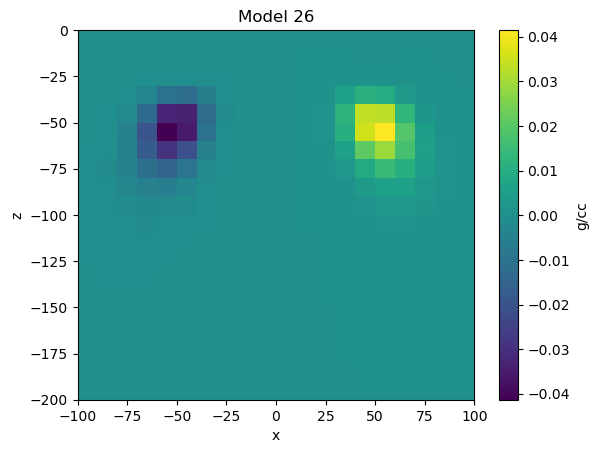

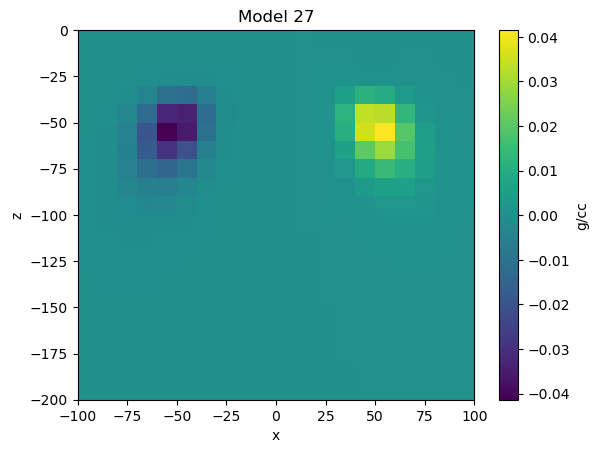

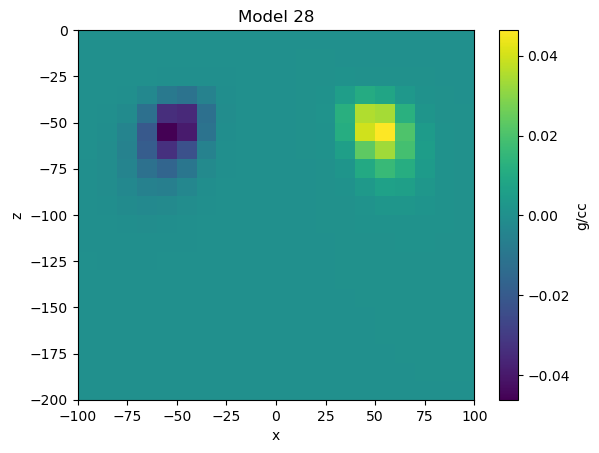

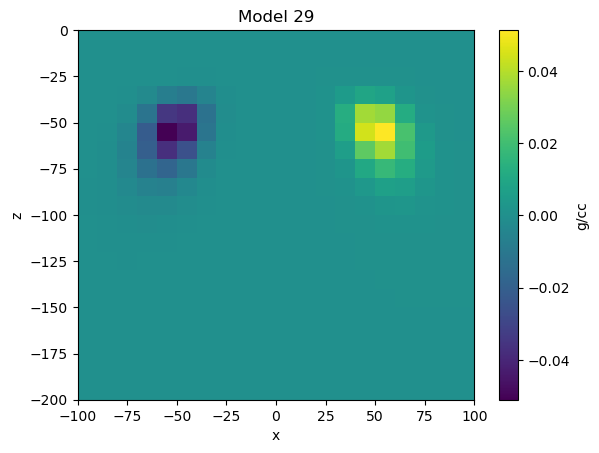

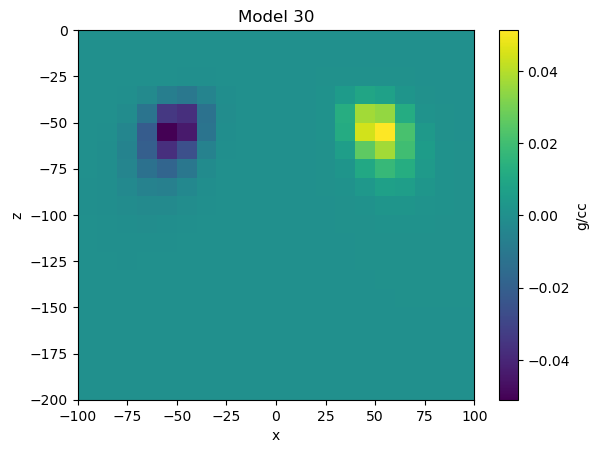

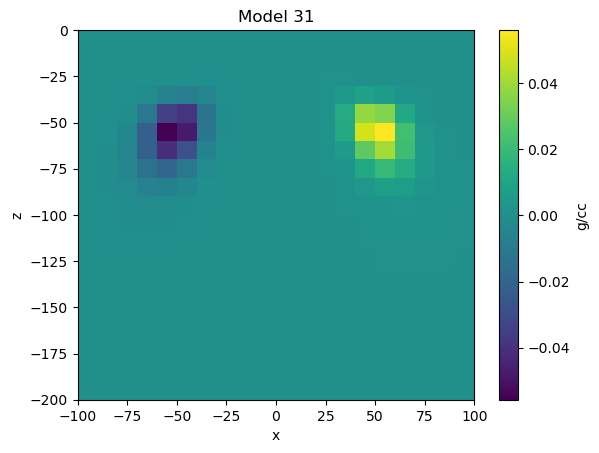

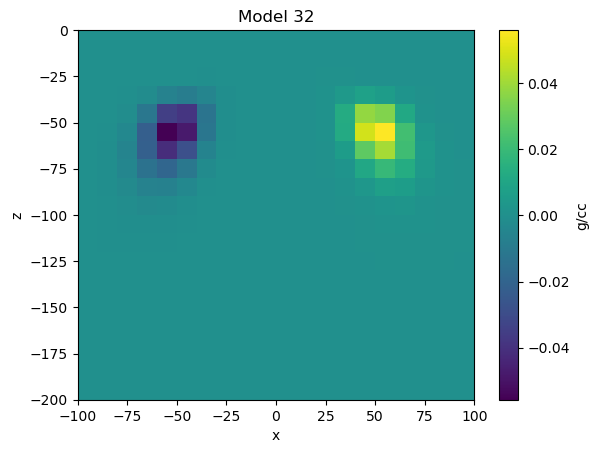

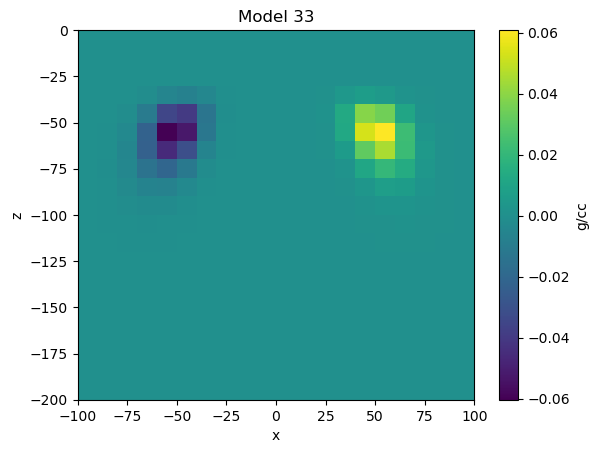

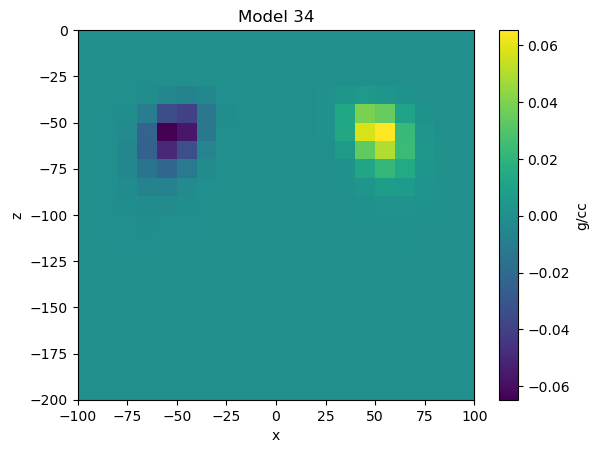

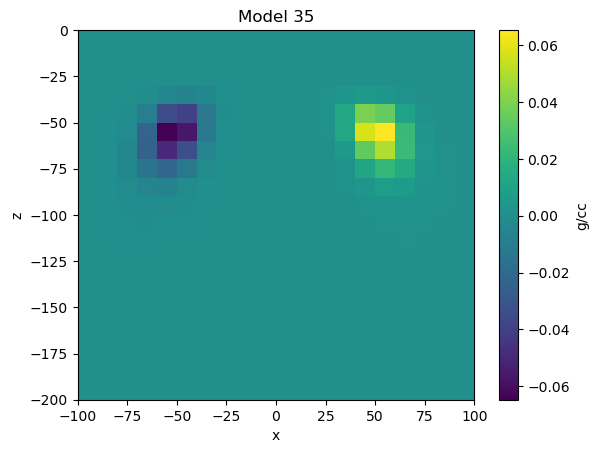

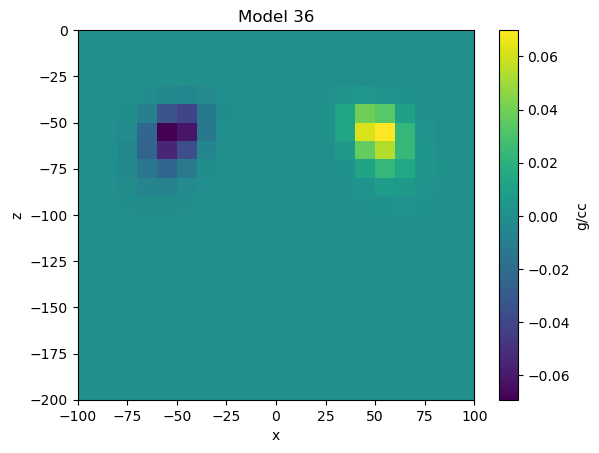

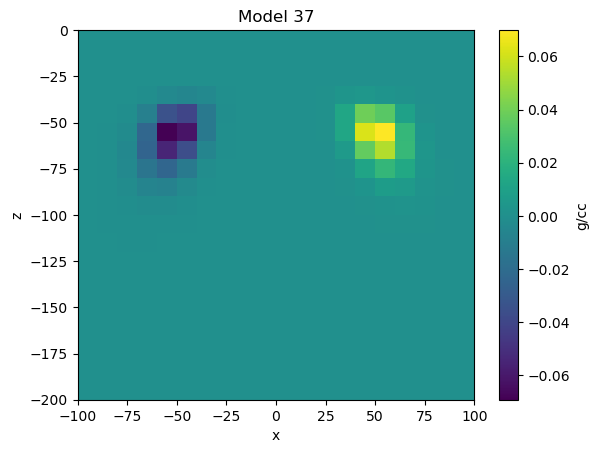

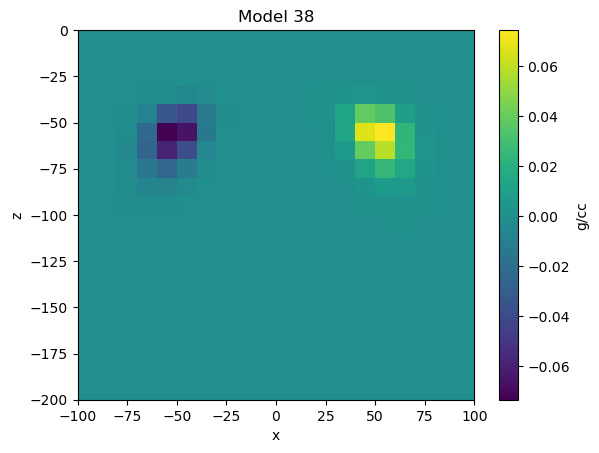

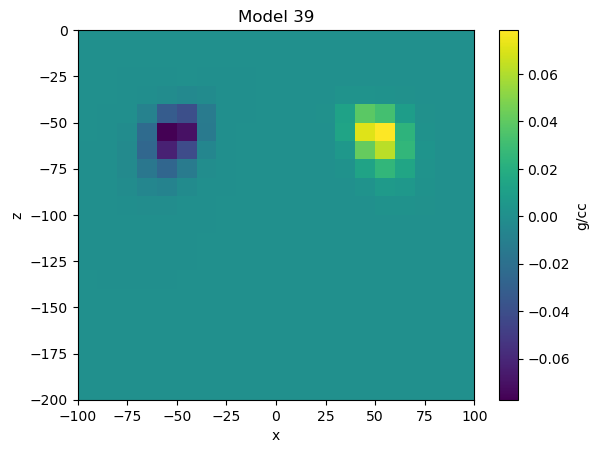

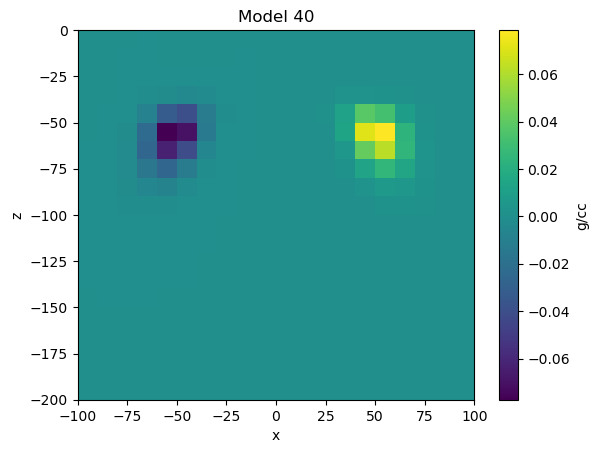

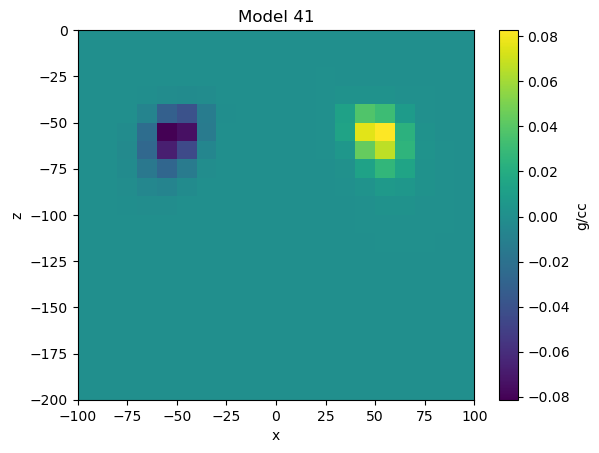

In [26]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()

In [31]:
models = sparse_inversion.models

diffs = [
    np.linalg.norm(models[i+1] - models[i]) / np.linalg.norm(models[i])
    for i in range(len(models) - 1)
]

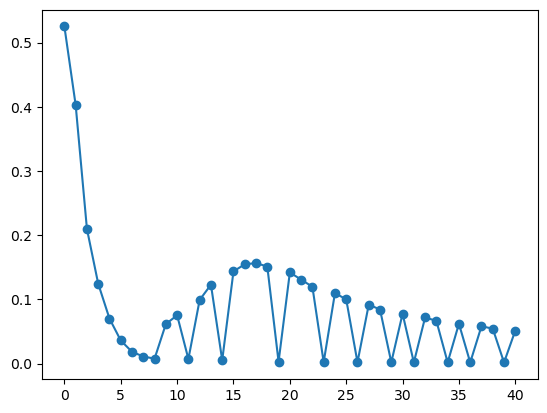

In [35]:
plt.plot(diffs, "o-")
plt.show()